In [1]:
library(tidyverse)
library(gridExtra)
library(ggExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [3]:
ppi_df <- read_tsv('../../data/2.edges/ppi.tsv.xz') %>% mutate(network='PPI')
biorxiv_df <- read_tsv('../../data/2.edges/biorxiv.tsv.xz') %>% mutate(network='Co-authorship')
tftg_df <- read_tsv('../../data/2.edges/tftg.tsv.xz') %>% mutate(network='TF-TG')

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)


In [4]:
vis_df <- bind_rows(
        ppi_df %>% mutate(data_source = 'PPI'), 
        biorxiv_df %>% mutate(data_source = 'bioRxiv')
    ) %>%
    select(-starts_with('name')) %>%
    gather(key = 'id_side', value = 'id', id_a:id_b) %>%
    group_by(id, network, data_source) %>%
    summarize_at(vars(train, test_recon, test_new), sum) %>%
    mutate(id_side = 'Undirected') %>%
    ungroup() %>%
    bind_rows(
        tftg_df %>%
            select(-starts_with('name')) %>%
            gather(key = 'id_side', value = 'id', id_a:id_b) %>%
            group_by(id, id_side, network) %>%
            summarize_at(vars(train, test_recon, test_new), sum) %>%
            ungroup() %>%
            mutate(data_source = id_side %>% 
                                     recode_factor(
                                         id_a = 'TF-TG transcription factor',
                                         id_b = 'TF-TG target gene'),)
    ) %>%
    gather('network', 'degree', train:test_new) %>%
    mutate(
        id_side = id_side %>% recode_factor(id_a = 'Source', id_b = 'Target'),
        network = network %>% recode_factor(train = 'Sampled', test_recon = 'Reconstructed', 
                                            test_new = 'Systematic')
    ) 

head(vis_df, 2)

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

id,data_source,id_side,network,degree
0,bioRxiv,Undirected,Sampled,12
0,PPI,Undirected,Sampled,55


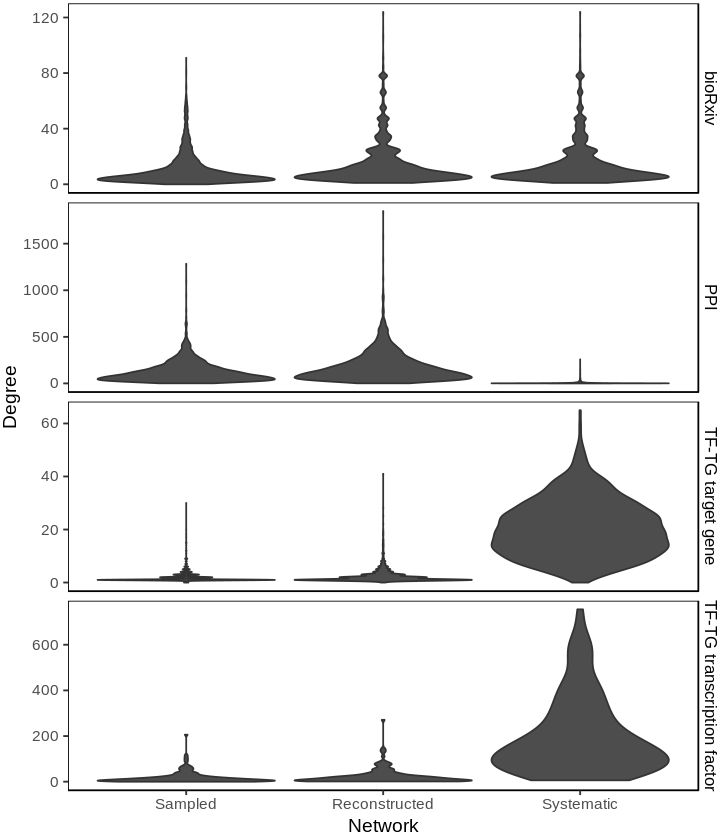

In [5]:
options(repr.plot.width=6, repr.plot.height=7)

g <- (
    ggplot(vis_df, aes(x = network, y = degree,))
    + geom_violin(scale = 'width', fill = 'grey30')
    + facet_grid(rows = vars(data_source), scales = 'free')
    + theme_zietzm()
    + xlab('Network')
    + ylab('Degree')
)

ggsave('../../img/supp/degree_violin.png', g, dpi = 500, width = 6, height = 7)

g